In [1]:
%matplotlib inline
%timeit

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import time
import pickle
import datetime
import re
import pyActigraphy

import sys
sys.path.append('/home/ngrav/project/')
from wearables.scripts import utils as wearutils
from wearables.scripts import data as weardata
from wearables.scripts import train as weartrain
from wearables.scripts import eval_ as weareval
from wearables.scripts import model as wearmodels
from wearables.scripts import DTW as weardtw

import torch
import torch.nn as nn
import torch.nn.functional as F

from scipy.spatial.distance import pdist, squareform
import fastdtw
import umap

plt.rc('font', size = 9)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['legend.frameon']=False
plt.rcParams['axes.grid']=False
plt.rcParams['legend.markerscale']=1
plt.rcParams['savefig.dpi'] = 600
sns.set_style("ticks")

In [2]:
# load data
mfp = '/home/ngrav/project/wearables/model_zoo'
bst_modelpkl = os.path.join(mfp, '213-itv52_InceptionTime_GA5.pkl')
bst_trainer = os.path.join(mfp, 'trainer_itv52_InceptionTime_GA5.pkl')

split = 'train'

X, md_model, trainer = weardtw.data_from_trainer(bst_trainer, split=split)

# call eval to get output, modify for return_hidden = True option
evaluation = weareval.eval_trained(trainer, split=split,
                                   modelpkl=bst_modelpkl,
                                   two_outputs=True)

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/torch/nn/modules/conv.py:294: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/aten/src/ATen/native/Convolution.cpp:660.)
  return F.conv1d(input, weight, bias, self.stride,
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [3]:
import functools
import operator
import torch
from torch.autograd import grad
import numpy as np
from tqdm import *

def gather_nd(params, indices):
    """
    Args:
        params: Tensor to index
        indices: k-dimension tensor of integers. 
    Returns:
        output: 1-dimensional tensor of elements of ``params``, where
            output[i] = params[i][indices[i]]
            
            params   indices   output
            1 2       1 1       4
            3 4       2 0 ----> 5
            5 6       0 0       1
    """
    max_value = functools.reduce(operator.mul, list(params.size())) - 1
    indices = indices.t().long()
    ndim = indices.size(0)
    idx = torch.zeros_like(indices[0]).long()
    m = 1

    for i in range(ndim)[::-1]:
        idx += indices[i]*m
        m *= params.size(i)

    idx[idx < 0] = 0
    idx[idx > max_value] = 0
    return torch.take(params, idx)

class PathExplainerTorch(object):
    def __init__(self, model):
        self.model = model
        return
    
    def _get_ref_tensor(self,baseline,batch_size,num_samples):
        number_to_draw = num_samples * batch_size
        replace = baseline.shape[0] < number_to_draw
        sample_indices = np.random.choice(baseline.shape[0],
                                          size=number_to_draw,
                                          replace=replace)
        ref_tensor = baseline[sample_indices,:]
        
        return ref_tensor

    def _get_samples_input(self, input_tensor, baseline, 
                           num_samples, use_expectation):
        '''
        calculate interpolation points
        Args:
            input_tensor: Tensor of shape (batch, ...), where ... indicates
                          the input dimensions. 
            reference_tensor: A tensor of shape (batch, k, ...) where ... 
                indicates dimensions, and k represents the number of background 
                reference samples to draw per input in the batch.
        Returns: 
            samples_input: A tensor of shape (batch, k, ...) with the 
                interpolated points between input and ref.
            samples_delta: A tensor of shape (batch, 1, ...) with the
                difference between input and reference for each sample
        '''
        input_dims = list(input_tensor.size())[1:]
        num_input_dims = len(input_dims)
        batch_size = input_tensor.size()[0]
        
        if use_expectation:
            reference_tensor = self._get_ref_tensor(baseline,batch_size,num_samples)
            shape = reference_tensor.shape
            reference_tensor = reference_tensor.view(
                    batch_size, 
                    num_samples, 
                    *(shape[1:]))
            
            # Grab a [batch_size, k]-sized interpolation sample
            t_tensor = torch.FloatTensor(batch_size, num_samples).uniform_(0,1).to(reference_tensor.device)
            shape = [batch_size, num_samples] + [1] * num_input_dims
            interp_coef = t_tensor.view(*shape)

            # Evaluate the end points
            end_point_ref = (1.0 - interp_coef) * reference_tensor

            input_expand_mult = input_tensor.unsqueeze(1)
            end_point_input = interp_coef * input_expand_mult

            # Affine Combine
            samples_input = end_point_input + end_point_ref
            
        else:
            batch_size = input_tensor.size()[0]
            input_expand = input_tensor.unsqueeze(1)
            reps = np.ones(len(baseline.shape)).astype(int)
            reps[0] = batch_size
            reference_tensor = baseline.repeat(list(reps)).unsqueeze(1)
#             reference_tensor = torch.as_tensor(sampled_baseline).unsqueeze(1).to(baseline.device)
            scaled_inputs = [reference_tensor + (float(i)/(num_samples-1))*(input_expand - reference_tensor) \
                             for i in range(0,num_samples)]
            samples_input = torch.cat(scaled_inputs,dim=1)
        
        samples_delta = self._get_samples_delta(input_tensor, reference_tensor)
        samples_delta = samples_delta.to(samples_input.device)
        
        return samples_input, samples_delta
    
    def _get_samples_delta(self, input_tensor, reference_tensor):
        input_expand_mult = input_tensor.unsqueeze(1)
        sd = input_expand_mult - reference_tensor
        return sd
    
    def _get_grads(self, samples_input, output_indices=None):

        grad_tensor = torch.zeros(samples_input.shape).float().to(samples_input.device)
        
        k_ = samples_input.shape[1]

        for i in range(k_):
            particular_slice = samples_input[:,i]
            batch_output = self.model(particular_slice)
            # should check that users pass in sparse labels
            # Only look at the user-specified label
            if batch_output.size(1) > 1:
                sample_indices = torch.arange(0,batch_output.size(0)).to(samples_input.device)
                indices_tensor = torch.cat([
                        sample_indices.unsqueeze(1), 
                        output_indices.unsqueeze(1)], dim=1)
                batch_output = gather_nd(batch_output, indices_tensor)

            model_grads = grad(
                    outputs=batch_output,
                    inputs=particular_slice,
                    grad_outputs=torch.ones_like(batch_output).to(samples_input.device),
                    create_graph=True)
            grad_tensor[:,i,:] = model_grads[0]
        return grad_tensor
           
    def attributions(self, input_tensor, baseline,
                     num_samples = 50, use_expectation=True, 
                     output_indices=None):
        """
        Calculate either Expected or Integrated Gradients approximation of 
        Aumann-Shapley values for the sample ``input_tensor``.
        Args:
            model (torch.nn.Module): Pytorch neural network model for which the
                output should be explained.
            input_tensor (torch.Tensor): Pytorch tensor representing the input
                to be explained.
            baseline (torch.Tensor): Pytorch tensor representing the baseline.
                If use_expectation is true, then baseline should be shape
                (num_refs, ...) where ... indicates the dimensionality
                of the input. Otherwise, baseline should be shape (1, ...).
            output_indices (optional, default=None): For multi-class prediction
        """
        equal_dims = baseline.shape[1:] == input_tensor.shape[1:]
        almost_equal_dims = baseline.shape == input_tensor.shape[1:]
        
        dev = input_tensor.device
        baseline = baseline.to(dev)
        
        input_tensor.requires_grad_ = True
        
        if use_expectation and not equal_dims:
            raise ValueError('baseline should be shape (num_refs, ...) \
                              where ... indicates the dimensionality   \
                              of the input')
            
        if not use_expectation and baseline.shape[0] != 1:
            if almost_equal_dims:
                baseline = baseline.unsqueeze(0)
            else:
                raise ValueError('baseline should be shape (...)           \
                                  where ... indicates the dimensionality   \
                                  of the input')
        
        samples_input, samples_delta = self._get_samples_input(input_tensor, baseline,
                                                               num_samples, use_expectation)
        grad_tensor = self._get_grads(samples_input, output_indices)
        mult_grads = samples_delta * grad_tensor
        attributions = mult_grads.mean(1)
        
        return attributions
    
    def interactions(self, input_tensor, baseline,
                     num_samples=50, use_expectation=True,
                     output_indices=None, interaction_index=None,
                     verbose=True):
        """
            input_tensor (torch.Tensor): Pytorch tensor representing the input
                to be explained.
            baseline (torch.Tensor): Pytorch tensor representing the baseline.
                If use_expectation is true, then baseline should be shape
                (num_refs, ...) where ... indicates the dimensionality
                of the input. Otherwise, baseline should be shape (1, ...)
            num_samples: The number of samples to use when computing the
                         expectation or integral.
            use_expectation: If True, this samples baselines and interpolation
                             constants uniformly at random (expected gradients).
                             If False, then this assumes num_refs=1 in which
                             case it uses the same baseline for all inputs,
                             or num_refs=batch_size, in which case it uses
                             baseline[i] for inputs[i] and takes 100 linearly spaced
                             points between baseline and input (integrated gradients).
            output_indices:  If this is None, then this function returns the
                             attributions for each output class. This is rarely
                             what you want for classification tasks. Pass an
                             integer tensor of shape [batch_size] to
                             index the output output_indices[i] for
                             the input inputs[i].
            interaction_index: Either None or an index into the input. If the latter,
                               will compute the interactions with respect to that
                               feature. This parameter should index into a batch
                               of inputs as inputs[(slice(None) + interaction_index)].
                               For example, if you had images of shape (32, 32, 3)
                               and you wanted interactions with respect
                               to pixel (i, j, c), you should pass
                               interaction_index=[i, j, c].
        
        """
        
        if len(input_tensor.shape) != 2:
            raise ValueError('PyTorch Explainer only supports ' + \
                             'interaction for 2D input tensors!')
        
        equal_dims = baseline.shape[1:] == input_tensor.shape[1:]
        almost_equal_dims = baseline.shape == input_tensor.shape[1:]
        
        if use_expectation and not equal_dims:
            raise ValueError('baseline should be shape (num_refs, ...) \
                              where ... indicates the dimensionality   \
                              of the input')
            
        if not use_expectation and baseline.shape[0] != 1:
            if almost_equal_dims:
                baseline = baseline.unsqueeze(0)
            else:
                raise ValueError('baseline should be shape (...)           \
                                  where ... indicates the dimensionality   \
                                  of the input')
        
        inner_loop_nsamples = int(round(np.sqrt(num_samples)))
        
        samples_input, samples_delta = self._get_samples_input(input_tensor, baseline,
                                                               inner_loop_nsamples, use_expectation)
        
        if interaction_index is not None:
            interaction_mult_tensor = torch.zeros([input_tensor.size(0), samples_input.size(1), input_tensor.size(1)])
        else:
            interaction_mult_tensor = torch.zeros([input_tensor.size(0), samples_input.size(1), 
                                                   input_tensor.size(1), input_tensor.size(1)])
            
        ig_tensor = torch.zeros(samples_input.shape).float()
        
        loop_num = inner_loop_nsamples
        
        if verbose:
            iterable = tqdm(range(loop_num))
        else:
            iterable = range(loop_num)
        
        for i in iterable:
            
            particular_slice = samples_input[:,i]
            ig_tensor[:,i,:] = self.attributions(particular_slice, baseline,
                                                 num_samples=inner_loop_nsamples, use_expectation=use_expectation,
                                                 output_indices=output_indices)
            
            if interaction_index is not None:
                second_grads = grad(
                        outputs=ig_tensor[:,i,interaction_index],
                        inputs=particular_slice,
                        grad_outputs=torch.ones_like(ig_tensor[:,i,interaction_index]),
                        create_graph=True)[0].detach()
                interaction_mult_tensor[:,i,:] = second_grads

            else:
                for feature in range(input_tensor.size(1)):
                    second_grads = grad(
                        outputs=ig_tensor[:,i,feature],
                        inputs=particular_slice,
                        grad_outputs=torch.ones_like(ig_tensor[:,i,feature]),
                        create_graph=True)[0].detach()
                    interaction_mult_tensor[:,i,feature,:] = second_grads

        interaction_mult_tensor = interaction_mult_tensor.to(samples_delta.device)
        if interaction_index is not None:
            interaction_tensor = interaction_mult_tensor * samples_delta
        else:
            interaction_tensor = interaction_mult_tensor * samples_delta.unsqueeze(2)
        interactions = interaction_tensor.mean(1)
        
        return interactions

In [4]:
explainer = PathExplainerTorch(evaluation.trainer.model)

In [5]:
# with open('/home/ngrav/project/wearables/results/errorgrp_dev_v52.pkl', 'rb') as f:
#     error_grps = pickle.load(f)
#     f.close()
    

In [7]:
pfp = '/home/ngrav/project/wearables/results/'

# filepaths to bst or pre-processed md with calculated metrics 
pp_md_fp = os.path.join(pfp, 'md_v522_220124.csv')

# load up to date md
md = pd.read_csv(pp_md_fp, index_col=0)

In [8]:
# redefine error groups
threshold = 10
md['Error group'] = 'lt{}wks'.format(threshold)
md.loc[(md['error'] >= threshold), 'Error group'] = 'Higher-than-actual'
md.loc[(md['error'] <= -threshold), 'Error group'] = 'Lower-than-actual'


In [30]:
md_model = md_model.merge(md.loc[:, [col for col in md.columns if col not in md_model.columns]], 
                          left_index=True, right_index=True, how='left')

In [31]:
error_grps = {}
for g in md_model['Error group'].unique():
    error_grps[g] = md_model.loc[(md_model['Error group'] == g)].index.to_list()

In [69]:
# select error groups 
n_samples = 100

# md_model['High Error Group'] = md_model.index.isin(error_grps['high'])
# md_model['Low Error Group'] = md_model.index.isin(error_grps['low'])
error_grp_sample = {k:list(np.random.choice(error_grps[k], n_samples)) for k in error_grps.keys()}
del error_grp_sample['lt10wks'] # only look at extremes for now
# error_grp_sample = {
#     'High actigraphy-GA': md_model.loc[md_model['High Error Group']].sample(n_samples).index.to_list(),
#     'Low actigraphy-GA': md_model.loc[md_model['Low Error Group']].sample(n_samples).index.to_list()}

In [70]:
def featattr_peruid(X, md, uids, explainer, trainer):
    '''
    Returns:
      df (pd.DataFrame)
      uids (dict): 'groupname': list of unique ids
    '''
    total_t = time.time()
    df = pd.DataFrame()
    counter = 0
    for i, g in enumerate(uids.keys()):
        for uid in uids[g]:
            idx = np.where(md.index==uid)[0].item()
            x = X[idx, :, :].unsqueeze(0)
            x.requires_grad = True
            print('starting idx: {}, unique id: {}\t{:.2f}-min elapsed'.format(idx, uid, (time.time()-total_t)/60))
            if counter==0: # only need to call once
                x_baseline = torch.zeros_like(x)
                x_baseline.requires_grad = True
            attr = explainer.attributions(input_tensor=x,
                                          baseline=x_baseline,
                                          num_samples=20,
                                          use_expectation=True,
                                          output_indices=0)
            dt = pd.DataFrame(attr[0, 0, :].detach().numpy(), columns=['attr'])
            dt['uid'] = uid
            dt['sleep'] = trainer.data.data['data'][uid]['sleep'][:-1].to_numpy()
            dt['group'] = g
            df = df.append(dt)
            counter += 1
    return df

In [71]:
res = featattr_peruid(X, md_model, error_grp_sample, explainer, trainer)

starting idx: 1319, unique id: 1247_4	0.00-min elapsed
starting idx: 600, unique id: 2112_11	0.15-min elapsed
starting idx: 1059, unique id: 1336_5	0.29-min elapsed
starting idx: 1566, unique id: 1527_9	0.42-min elapsed
starting idx: 790, unique id: 1090_3	0.55-min elapsed
starting idx: 450, unique id: 1301_8	0.68-min elapsed
starting idx: 1547, unique id: 1436_6	0.81-min elapsed
starting idx: 1560, unique id: 2350_7	0.94-min elapsed
starting idx: 508, unique id: 2527_8	1.07-min elapsed
starting idx: 1250, unique id: 1594_7	1.20-min elapsed
starting idx: 729, unique id: 1858_7	1.33-min elapsed
starting idx: 1557, unique id: 2396_6	1.46-min elapsed
starting idx: 392, unique id: 1723_9	1.59-min elapsed
starting idx: 1553, unique id: 1408_6	1.72-min elapsed
starting idx: 1130, unique id: 1302_5	1.85-min elapsed
starting idx: 790, unique id: 1090_3	1.98-min elapsed
starting idx: 199, unique id: 2030_8	2.11-min elapsed
starting idx: 1395, unique id: 2437_9	2.24-min elapsed
starting idx: 151

# compare sleep v. wake attribution

In [72]:
from scipy.stats import mannwhitneyu

In [73]:
res.head()

,attr,uid,sleep,group
0,0.000000,1247_4,1,Higher-than-actual
1,0.000000,1247_4,1,Higher-than-actual
2,0.000000,1247_4,1,Higher-than-actual
3,-0.021678,1247_4,1,Higher-than-actual
4,-0.019088,1247_4,0,Higher-than-actual


In [48]:
# res.loc[(res['group']=='High actigraphy-GA') & (res['sleep']==1), 'attr'].to_numpy().mean() - res.loc[(res['group']=='Low actigraphy-GA') & (res['sleep']==1), 'attr'].to_numpy().mean()

In [137]:
# sleep
a = res.loc[(res['group']=='Higher-than-actual') & (res['sleep']==1), 'attr'].to_numpy()
b = res.loc[(res['group']=='Lower-than-actual') & (res['sleep']==1), 'attr'].to_numpy()

mannwhitneyu(a, b)

MannwhitneyuResult(statistic=220566212896.5, pvalue=1.6198736781249616e-50)

In [142]:
np.abs(np.mean(a)) - np.abs(np.mean(b))

0.0001233005

In [ ]:
res['abs_attr'] = res['attr'].abs()

In [171]:
res['abs_attr'].quantile(0.999)

0.38815289673210157

/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figur

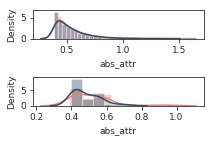

In [ ]:
dt = res.loc[res['abs_attr']>=res['abs_attr'].quantile(0.999)]

fig, ax = plt.subplots(2, 1, figsize=(3,2))
sns.distplot(dt.loc[(dt['sleep']==0) & (dt['group']=='Higher-than-actual'), 'abs_attr'], color='#E57F84', label='Higher-than-actual', ax=ax[0])
sns.distplot(dt.loc[(dt['sleep']==0) & (dt['group']=='Lower-than-actual'), 'abs_attr'], color='#2F5061', label='Lower-than-actual', ax=ax[0])

sns.distplot(dt.loc[(dt['sleep']==1) & (dt['group']=='Higher-than-actual'), 'abs_attr'], color='#E57F84', label='Higher-than-actual', ax=ax[1])
sns.distplot(dt.loc[(dt['sleep']==1) & (dt['group']=='Lower-than-actual'), 'abs_attr'], color='#2F5061', label='Lower-than-actual', ax=ax[1])
fig.tight_layout()

fig.savefig(os.path.join(pfp, 'distplot_wakeVsleep_errgrp_upperthousandth.pdf'))

In [169]:
# sns.distplot(
#     res.loc[((
#     ((res['attr'] >= (1e-12)) & (res['attr']>=0)) | 
#     ((res['attr'] <= -(1e-12)) & (res['attr']<0))) & 
#     (res['sleep']==0) & (res['group']=='Higher-than-actual')), 'attr'], color='#333652', label='Higher-than-actual')
# sns.distplot(
#     res.loc[((
#     ((res['attr'] >= (1e-12)) & (res['attr']>=0)) | 
#     ((res['attr'] <= -(1e-12)) & (res['attr']<0))) & 
#     (res['sleep']==0) & (res['group']=='Lower-than-actual')), 'attr'], color='#90ADC6', label='Lower-than-actual')

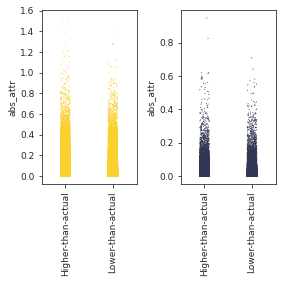

In [145]:
fig, ax = plt.subplots(1, 2, figsize=(4, 4))
sns.stripplot(x='group', y='abs_attr', 
              data=res.loc[((
    ((res['attr'] >= (1e-12)) & (res['attr']>=0)) | 
    ((res['attr'] <= -(1e-12)) & (res['attr']<0))) & 
    (res['sleep']==0)), :], 
              hue='sleep', rasterized=True, s=1, ax=ax[0], palette={0:'#FAD02C', 1:'#333652'},
             )
sns.stripplot(x='group', y='abs_attr', 
              data=res.loc[((
    ((res['attr'] >= (1e-12)) & (res['attr']>=0)) | 
    ((res['attr'] <= -(1e-12)) & (res['attr']<0))) & 
    (res['sleep']==1)), :], 
              hue='sleep', rasterized=True, s=1, ax=ax[1], palette={0:'#FAD02C', 1:'#333652'},
             )
ax[0].legend().set_visible(False)
ax[1].legend().set_visible(False)
ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)
fig.tight_layout()
fig.savefig(os.path.join(pfp, 'stripplot_featattrVerrorgrp.pdf'))

In [ ]:
n_comparisons = 4
# sleep
a = res.loc[(res['group']=='High actigraphy-GA') & (res['sleep']==1), 'attr'].to_numpy()
b = res.loc[(res['group']=='Low actigraphy-GA') & (res['sleep']==1), 'attr'].to_numpy()

statistic, p = mannwhitneyu(a, b)
p = p*n_comparisons
p

In [82]:
# sleep, groupbed by uid
a = res.loc[(res['group']=='Higher-than-actual') & (res['sleep']==1), :].groupby('uid').mean()['attr'].to_numpy()
b = res.loc[(res['group']=='Lower-than-actual') & (res['sleep']==1), :].groupby('uid').mean()['attr'].to_numpy()

mannwhitneyu(a, b)

MannwhitneyuResult(statistic=2431.0, pvalue=0.004680970542715164)

In [83]:
# wake
a = res.loc[(res['group']=='Higher-than-actual') & res['sleep']!=1, 'attr'].to_numpy()
b = res.loc[(res['group']=='Lower-than-actual') & res['sleep']!=1, 'attr'].to_numpy()

mannwhitneyu(a, b)

MannwhitneyuResult(statistic=905197214273.5, pvalue=0.0014525912454601264)

In [84]:
# wake, grouped by uid
a = res.loc[(res['group']=='Higher-than-actual') & (res['sleep']!=1), :].groupby('uid').mean()['attr'].to_numpy()
b = res.loc[(res['group']=='Lower-than-actual') & (res['sleep']!=1), :].groupby('uid').mean()['attr'].to_numpy()

mannwhitneyu(a, b)

MannwhitneyuResult(statistic=0.0, pvalue=0.0)

In [132]:
# sleep - wake, grouped by uid
a = (res.loc[(res['group']=='Higher-than-actual') & (res['sleep']==1), :].groupby('uid').mean()['attr'] - res.loc[(res['group']=='High actigraphy-GA') & (res['sleep']!=1), :].groupby('uid').mean()['attr']).to_numpy()
b = (res.loc[(res['group']=='Lower-than-actual') & (res['sleep']==1), :].groupby('uid').mean()['attr'] - res.loc[(res['group']=='Low actigraphy-GA') & (res['sleep']!=1), :].groupby('uid').mean()['attr']).to_numpy()

mannwhitneyu(a, b)

MannwhitneyuResult(statistic=342.0, pvalue=1.0541184417863536e-22)

# questions

## association btw importance and time of (...)

time of day: weekend vs. weekday, morning vs. evening, sleep v. wake; day vs. night

In [244]:
def featattr_peruid(X, md, uids, explainer, trainer):
    '''
    Returns:
      df (pd.DataFrame)
      uids (dict): 'groupname': list of unique ids
    '''
    total_t = time.time()
    df = pd.DataFrame()
    counter = 0
    for i, g in enumerate(uids.keys()):
        for uid in uids[g]:
            idx = np.where(md.index==uid)[0].item()
            x = X[idx, :, :].unsqueeze(0)
            x.requires_grad = True
            print('starting idx: {}, unique id: {}\t{:.2f}-min elapsed'.format(idx, uid, (time.time()-total_t)/60))
            
            if counter==0: # only need to call once, unless want to add salt & pepper noise
                x_baseline = torch.zeros_like(x)
                x_baseline.requires_grad = True
                
            attr = explainer.attributions(input_tensor=x,
                                          baseline=x_baseline,
                                          num_samples=20,
                                          use_expectation=True,
                                          output_indices=0)
            dt = pd.DataFrame(attr[0, 0, :].detach().numpy(), columns=['attr'])
            dt['uid'] = uid
            
            # sleep or wake
            dt['sleep'] = trainer.data.data['data'][uid]['sleep'][:-1].to_numpy()
            
            t = trainer.data.data['data'][uid]['t'][:-1]
            dt['t'] = t.to_list() # does this preserve?
            
            # morning or evening
            dt['morningVevening'] = 'NA'
            dt.loc[((t.apply(lambda x: x.time()) >= datetime.time(hour=6)) & (t.apply(lambda x: x.time()) < datetime.time(hour=12))).to_list(),
                   'morningVevening'] = 'Morning'
            dt.loc[((t.apply(lambda x: x.time()) >= datetime.time(hour=18)) & (t.apply(lambda x: x.time()) <= datetime.time(hour=23, minute=59))).to_list(),
                   'morningVevening'] = 'Evening'
            
            # weekday or weekend
            dt['weekdayVweekend'] = 'Weekday'
            dt.loc[((t.apply(lambda x: x.weekday()) == 5) | (t.apply(lambda x: x.weekday()) == 6)).to_list(),
                   'weekdayVweekend'] = 'Weekend'
            
            # daytime, nighttime
            dt['dayVnight'] = 'Night'
            dt.loc[((t.apply(lambda x: x.time()) >= datetime.time(hour=6)) & (t.apply(lambda x: x.time()) < datetime.time(hour=18))).to_list(), 
                   'dayVnight'] = 'Day'
            
            dt['group'] = g
            df = df.append(dt)
            counter += 1
    return df

In [245]:
# sample low error group, then examine globally on them:
n_samples = 100
lt2wk = {'lt2wk': md_model.loc[(md_model['error'].abs() <= 2), :].sample(n_samples, replace=False).index.to_list()}

In [ ]:
res_lt2wk = featattr_peruid(X, md_model, lt2wk, explainer, trainer)

starting idx: 779, unique id: 2125_14	0.00-min elapsed


In [ ]:
res_lt2wk

# plot single examples

In [111]:
savefigs=True

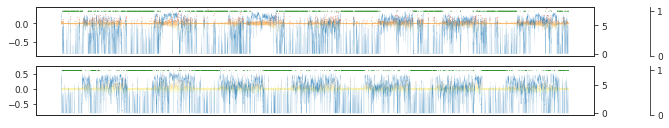

In [115]:
sleep = trainer.data.data['data'][uid_ptb]['sleep'][:-1]
sleep.replace(0, np.nan, inplace=True)
fig, ax = plt.subplots(2, 1, figsize=(10, 2)) 
ax[0].scatter(np.arange(x.shape[-1]), attr_ptb[0, 0, :].detach(), c=attr_ptb[0, 0, :].detach(), cmap='RdYlBu_r', s=0.5, rasterized=True, edgecolor='none')
par2 = ax[0].twinx()
par2.plot(np.arange(x.shape[-1]), x[0, 0, :].detach(), linewidth=0.1, alpha=0.75, rasterized=True)
# par2.set_ylabel('Activity (log pseudocounts)')
par3 = ax[0].twinx()
par3.set_ylim(0, 1.1)
par3.scatter(np.arange(x.shape[-1]), sleep, linewidth=0.1, color='green', s=0.1, rasterized=True, edgecolor='none')
par3.spines.right.set_position(("axes", 1.1))
ax[0].set_xticks([])

sleep_noptb = trainer.data.data['data'][uid_noptb]['sleep'][:-1]
sleep_noptb.replace(0, np.nan, inplace=True)
ax[1].scatter(np.arange(x.shape[-1]), attr_noptb[0, 0, :].detach(), c=attr_noptb[0, 0, :].detach(), cmap='RdYlBu_r', s=0.5, rasterized=True, edgecolor='none')
par2 = ax[1].twinx()
par2.plot(np.arange(x.shape[-1]), x_noptb[0, 0, :].detach(), linewidth=0.1, alpha=0.75, rasterized=True)
# par2.set_ylabel('Activity (log pseudocounts)')
par3 = ax[1].twinx()
par3.set_ylim(0, 1.1)
par3.scatter(np.arange(x.shape[-1]), sleep_noptb, linewidth=0.1, color='green', s=0.1, rasterized=True, edgecolor='none')
par3.spines.right.set_position(("axes", 1.1))
ax[1].set_xticks([])

if savefigs:
    fig.savefig('/home/ngrav/project/wearables/results/ptbVnoptb_pathexpattr.png', bbox_inches='tight', dpi=600)

In [132]:
df_sleep = pd.DataFrame({'sleep': sleep.replace(np.nan, 0).to_list(), 'importance': attr_ptb[0, 0, :].detach().numpy(), 'md':['ptb']*sleep.shape[0]})
dt = pd.DataFrame({'sleep': sleep_noptb.replace(np.nan, 0).to_list(), 'importance': attr_noptb[0, 0, :].detach().numpy(), 'md':['noptb']*sleep_noptb.shape[0]})
df_sleep = df_sleep.append(dt)
del dt

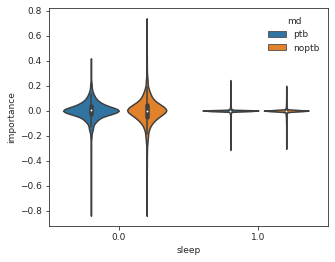

In [138]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
sns.violinplot(x='sleep', y='importance', hue='md', data=df_sleep, ax=ax)
# sns.swarmplot(x='sleep', y='importance', hue='md', data=df_sleep, ax=ax)
if savefigs:
    fig.savefig('/home/ngrav/project/wearables/results/violin_ptbVnoptb_bysleep_pathexpattr.png', bbox_inches='tight', dpi=600)

# correlations with error

show corr net, only significant ones can retain edge

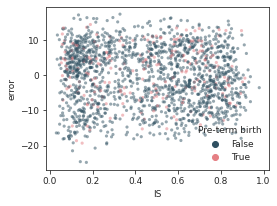

In [45]:
ptb_cmap = {False: '#2F5061', True: '#E57F84'}
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
sns.scatterplot(x='IS', y='error', data=md.loc[md['split']=='train'], hue='Pre-term birth',
                palette=ptb_cmap, linewidth=0, s=10, alpha=0.5, rasterized=True, ax=ax)
fig.savefig(os.path.join(pfp, 'scatter_errorVIS_train.pdf'), bbox_inches='tight')

## mask or stratify by feature importance